# Make Simulated Neurons

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import plotly.express as px
import sys


sys.path.append('../')
from data_prep import generate, draw, load

## Generate simulated SWC file data.
This is a list of nodes, each node being a list:
[sample_idx, structure_id, x, y, z, radius, parent_id]

In [3]:
swc_list = generate.make_swc_list((101,101,101),
                        length=20,
                        step_size=3,
                        kappa=20.0,
                        uniform_len=False,
                        random_start=True,
                        rng=None,
                        num_branches=1) # make simulated neuron paths.

Set random background and foreground (neuron) colors

In [4]:
random_contrast=True
if random_contrast:
    neuron_color = np.random.rand(3)
    neuron_color /= np.linalg.norm(neuron_color)
    background = np.random.rand(3)
    background = background / np.linalg.norm(background) * 0.01

Draw neurons from SWC format data; one without and one with added noise and artifacts.

In [5]:
neuron_no_artifacts = draw.neuron_from_swc(swc_list,
                                width=3,
                                noise=0.0,
                                adjust=False,
                                neuron_color=None,
                                background_color=None,
                                random_brightness=False,
                                dropout=False,
                                binary=False)

neuron_with_artifacts = draw.neuron_from_swc(swc_list,
                                width=3,
                                noise=0.05,
                                adjust=False,
                                neuron_color=neuron_color,
                                background_color=background,
                                random_brightness=True,
                                dropout=True,
                                binary=False)



## Draw the images.
    a. Without artifacts

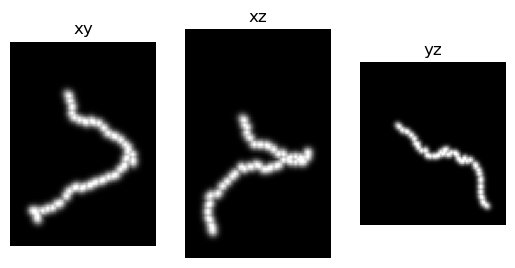

In [17]:
img = neuron_no_artifacts["image"].data.permute(1,2,3,0)

fig, ax = plt.subplots(1,3)
ax[0].imshow(img.amax(0))
ax[0].set_title('xy')
ax[1].imshow(img.amax(1))
ax[1].set_title('xz')
ax[2].imshow(img.amax(2))
ax[2].set_title('yz')
for x in ax:
    x.set_axis_off()
plt.show()

    b. With artifacts

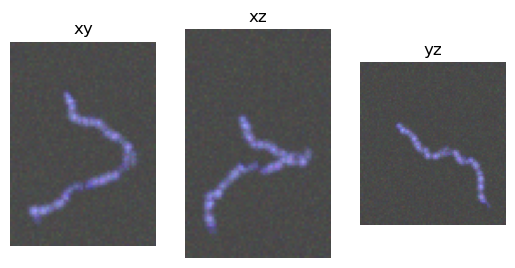

In [18]:
img = neuron_with_artifacts["image"].data.permute(1,2,3,0)

fig, ax = plt.subplots(1,3)
ax[0].imshow(img.amax(0))
ax[0].set_title('xy')
ax[1].imshow(img.amax(1))
ax[1].set_title('xz')
ax[2].imshow(img.amax(2))
ax[2].set_title('yz')
for x in ax:
    x.set_axis_off()
plt.show()

## Simulate from existing SWC file

### Load real neuron morphology data from an SWC file

In [8]:
labels_dir = "/home/brysongray/data/neuromorpho/"
files = [f for x in os.walk(labels_dir) for f in glob(os.path.join(x[0], '*.swc'))]

f_idx = 4
labels_file = files[f_idx]
# load and parse the SWC file data
swc_list = load.swc(labels_file)
sections, section_graph, branches, terminals, scale = load.parse_swc_list(swc_list, adjust=True)

loading file: /home/brysongray/data/neuromorpho/quinlan/CNG version/KQa4-12-2015-tracing.CNG.swc


In [3]:
# labels_file = "/home/brysongray/data/gold166/e_checked6_chick_uw/DONE_09-2902-04R-01C-60x_merge_c1/09-2902-04R-01C-60x_merge_c1.v3dpbd.swc"
labels_file = "/home/brysongray/data/gold166/e_checked6_chick_uw/DONE_case1-slide2-section1-left-cell1_merge_c2/case1-slide2-section1-left-cell1_merge_c2.v3dpbd.swc"
# load and parse the SWC file data
swc_list = load.swc(labels_file)
sections, sections_graph = load.parse_swc(swc_list)
branches, terminals = load.get_critical_points(swc_list, sections)

loading file: /home/brysongray/data/gold166/e_checked6_chick_uw/DONE_case1-slide2-section1-left-cell1_merge_c2/case1-slide2-section1-left-cell1_merge_c2.v3dpbd.swc


### Plot SWC raw data

In [4]:
# Create a DataFrame for plotting
data = []
# Iterate through the sections dictionary
for section_id, section_data in sections.items():
    # flatten the section into one list of consecutive points instead of segments (point pairs)
    for i,segment in enumerate(section_data):
        point = segment[0] 
        data.append([section_id, point[0].item(), point[1].item(), point[2].item()])
        if i == len(section_data)-1:
            point = segment[1]
            data.append([section_id, point[0].item(), point[1].item(), point[2].item()])
df_sections = pd.DataFrame(data, columns=["section", "x", "y", "z"])

fig = px.line_3d(df_sections, x="x", y="y", z="z", color='section', )
fig.update_layout(scene_aspectmode='data')
fig.show()

In [23]:
# Create a DataFrame for plotting
data = []
# Iterate through the sections dictionary
for section_id, section_data in sections.items():
    # flatten the section into one list of consecutive points instead of segments (point pairs)
    for i,segment in enumerate(section_data):
        point = segment[0] 
        data.append([section_id, point[0].item(), point[1].item(), point[2].item()])
        if i == len(section_data)-1:
            point = segment[1]
            data.append([section_id, point[0].item(), point[1].item(), point[2].item()])
df_sections = pd.DataFrame(data, columns=["section", "x", "y", "z"])

fig = px.line_3d(df_sections, x="x", y="y", z="z", color='section', )
fig.update_layout(scene_aspectmode='data')
fig.show()

### Simulate a neuron microscopy image with artifacts from the SWC data

Set random colors for the background and foreground voxels. 

In [5]:
random_contrast = True

rng = np.random.default_rng()
neuron_color = np.array([1.0, 1.0, 1.0])
background = np.array([0., 0., 0.])
if random_contrast:
    neuron_color = rng.uniform(size=3)
    neuron_color /= np.linalg.norm(neuron_color)
    background_color = rng.uniform(size=3)
    background_color = background_color / np.linalg.norm(background_color) * 0.01

Draw the neuron image

In [16]:

swc_data = draw.neuron_from_swc(swc_list,
                                width=3,
                                noise=0.00,
                                dropout=False,
                                adjust=False,
                                background_color=background,
                                neuron_color=neuron_color,
                                random_brightness=False,
                                binary=False,
                                rng=rng)

Plot

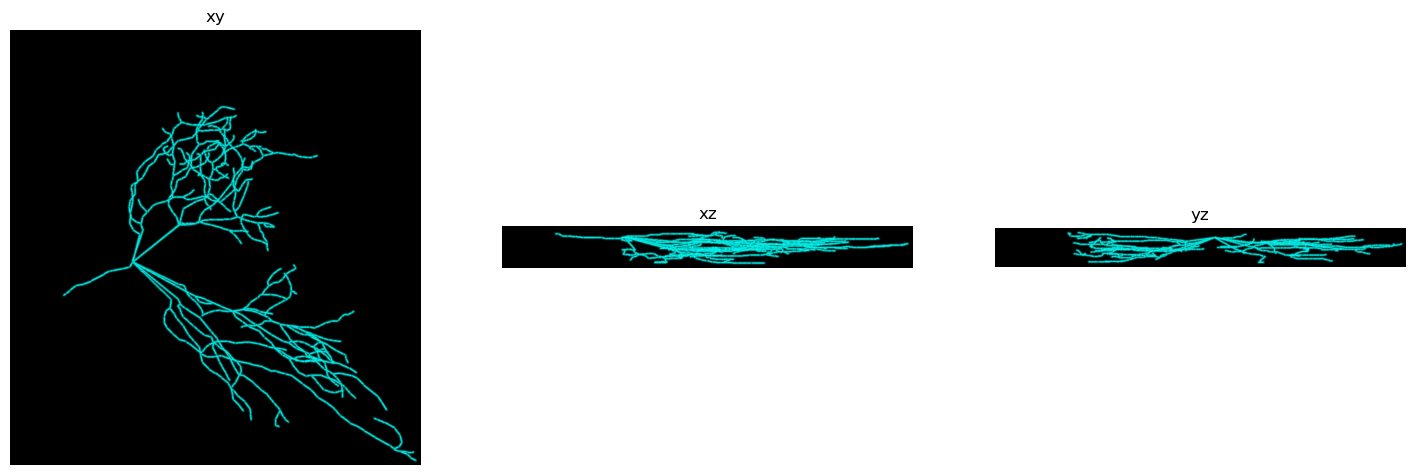

In [17]:
img = swc_data["image"].data.permute(1,2,3,0)

fig, ax = plt.subplots(1,3, figsize=(18,6))
ax[0].imshow(img.amax(0))
ax[0].set_title('xy')
ax[1].imshow(img.amax(1))
ax[1].set_title('xz')
ax[2].imshow(img.amax(2))
ax[2].set_title('yz')
for x in ax:
    x.set_axis_off()
plt.show()